# Programming Assignment 2: Support Vector Machine

## Remarks:
1. Please complete the theoretical questions directly in this notebook using `markdown`. We do not accept handwritten PA submissions.
2. You will use `cvxopt` package in this assignment. To ensure consistency of notation, please use `pip install cvxopt==1.2.7` to install a suitable version (1.3.0 version may encounter problems)
3. You will use `torch` to implement binary classification and `torchvision` to load MNIST dataset. `tqdm` is used to show the learning progress.

In [ ]:
# ! pip install cvxopt
# ! pip install scikit-learn
# ! pip install torch torchvision tqdm
# Already installed in the environment by terminal

## Recap of Soft-margin SVM Optimization Problem
A SVM computes a hyperplane classifier of the form $f(x)=w^{T}x+b$, where $w$ is the normal vector to the hyperplane, $x$ is the input vector and $b$ is the bias scalar. Since we apply it to a binary classification problem, we will ultimately predict label $y = 1$ if $f(x) ≥ 0$ and $y = −1$ if $f(x) < 0$. By deriving the dual form of the SVM problem, we convert the original non-convex problem into a Quadratic Programming (QP) problem over a set of Lagrange multipliers $\alpha=\{ \alpha_1,\alpha_2,\ldots,\alpha_N\}$ . 

Consider a dataset with $N$ samples $\{x_1,x_2,\ldots,x_N\}$. The soft-margin SVM algorithm tries to solve:

$$\begin{array}{rc}\underset{\alpha}{max} &\sum\limits^N_{i=1}\alpha_i-\frac{1}{2}\sum\limits^N_{i=1}\sum\limits^N_{j=1}\alpha_i\alpha_jy_iy_jK(x_i,x_j) \\ \text { s.t. } & \sum\limits^N_{i=1}\alpha_iy_i=0, \\ & 0 \leqslant \alpha_i \leqslant C,i=1,2,\ldots,N.\end{array}$$

where $C$  is the penalty parameter. $K$ is the kernel function, which allow us to learn non-linear decision function through feature mapping. When an inner product is used (e.g. $K(x_i,x_j)=\langle x_i,x_j\rangle$ ), the model degenerates into a linear SVM. We can also represent the kernel function as a symmetric matrix $K_{i,j} = K(x_i, x_j)$. 

After finding the optimal solution $\alpha^{*}$ , we could obtain the optimal $w^*$ and $b^*$ and then derive the decision function for classification: 
$f(x)=\sum\limits_{i=1}^{N} \alpha_{i}^{*} y_{i} K\left(x, x_{i}\right)+b^{*}.$ The KKT conditions can be used to check for convergence to the optimal solution. In other words, any $\alpha$ that satisfy these properties will be an optimal solution to the
optimization problem given above. For this problem the KKT conditions are:
$$
\begin{aligned}
\alpha_i=0 & \Rightarrow y^{(i)}\left(w^T x^{(i)}+b\right) \geq 1 \\
\alpha_i=C & \Rightarrow y^{(i)}\left(w^T x^{(i)}+b\right) \leq 1 \\
0<\alpha_i<C & \Rightarrow y^{(i)}\left(w^T x^{(i)}+b\right)=1.
\end{aligned}
$$

In this assignment, we will introduce two different ways of solving $\alpha^{*}$.

## Part I: SVM as a Quadratic Programming Problem

### Solving QP Problem with CVXOPT Package

In this section, we will use a Python package `cvxopt` to see how SVM works. The `cvxopt` is widely used in solving optimization problems. We are also going to use `numpy`, `pandas`, `random`, `seaborn` and `matplotlib` packages to help us. The first thing we need to do is to import them.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cvxopt
from cvxopt import matrix, solvers
from sklearn import datasets

%matplotlib inline

QP solves quadratic optimization problems, to optimize a multivariate quadratic function subject with linear constraints on the variables. They can be solved via the solvers.qp() function in `cvxopt`. The standard form of a QP (following CVXOPT notation) is:

$$\begin{array}{rc}\underset{x}{min}  & \frac{1}{2} x^{\mathrm{T}} P x+q^{\mathrm{T}} x \\ \text { s.t. } & G x \preceq h, \\ & A x=b.\end{array}$$

#### Q1. Before using it to solve SVM, we need to transform the soft-margin SVM optimization problem above into the standard form. Please derive corresponding $P,q,G,h,A,b$ here and show the derivation steps.

*Your Answer:*
$$
P = \left[ y_i y_j K(x_i, x_j) \right]_{i,j=1}^N \\
q = -\mathbf{1} \\
G = \begin{bmatrix}
-I \\
I
\end{bmatrix}, \quad h = \begin{bmatrix}
0 \\
C 
\end{bmatrix} \\
A = \begin{bmatrix}
y_1 & y_2 & \cdots & y_N
\end{bmatrix}, \quad b = 0
$$

Derivation: 

1. **Objective Function**:
    The original problem is:
   $$
   \underset{\alpha}{\max} \sum_{i=1}^{N} \alpha_i - \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j K(x_i, x_j).
   $$
    This can be rewritten as a minimization problem:
   $$
   \underset{\alpha}{\min} \quad \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j K(x_i, x_j) - \sum_{i=1}^{N} \alpha_i.
   $$
    In matrix form, this becomes:
   $$
   \frac{1}{2} \alpha^T P \alpha + q^T \alpha.
   $$
    Here, $ P $ is derived from the quadratic term $ \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j K(x_i, x_j) $. Hence:
   $$
   P = \left[ y_i y_j K(x_i, x_j) \right]_{i,j=1}^N.
   $$
   $q$ is the vector corresponding to the linear term $ -\sum_{i=1}^{N} \alpha_i $ leads to:
   $$
   q_i = -1 \quad \text{for all } i.
   $$
    where $ \mathbf{1} $ is an $ N $-dimensional vector of ones.
    
3. **Equality Constraints**:
   
   The constraint $ \sum_{i=1}^{N} \alpha_i y_i = 0 $ can be expressed in the form $ A \alpha = b $, where:
   
   * $A$ is a row vector $A = \begin{bmatrix}y_1 , y_2, \cdots ,y_N\end{bmatrix}$.
   * $b$ is a scalar $b=0$.
   
4. **Inequality Constraints**:
   - The constraints $ 0 \leq \alpha_i \leq C $ can be expressed as two sets of inequalities:
     - $ \alpha_i \geq 0 $ leads to $ -\alpha_i \leq 0 $.
     - $ \alpha_i \leq C $ leads to $ \alpha_i \leq C $.
   - Therefore, the matrix $ G $ and vector $ h $ are:
     $$
     G = \begin{bmatrix}
     -I_N \\
     I_N
     \end{bmatrix}, \quad h = \begin{bmatrix}
     0 \\
     C 
     \end{bmatrix},
     $$
     where $ I $ is the identity matrix of size $ N $.


#### Q2. Now use `numpy` and `cvxopt` to implement soft-margin SVM algorithm in the form of QP problem. Check this document for its usage: https://cvxopt.org/examples/tutorial/qp.html. (Remark: the data type of matrix objects for qp function should be double)

In [3]:
def linear_kernel(x1,x2):
    return np.dot(x1,x2)

def kernel_matrix(X, n_samples, kernel):
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j])
    return K

In [10]:
def svm_qp(X, y, C , kernel=linear_kernel):
    # X: feature matrix, X[i,:] is the vector x_i
    # y: labels
    # C: soft-margin parameter
    # kernel: kernel function. default linear kernel
    # return optimal alpha and b of SVM

    N, n_features = X.shape
    K = kernel_matrix(X, N, kernel)
    """ Your Code here """
    # Convert labels into a column vector
    y = y.astype(float).reshape(-1, 1)

    # P = K_{ij} * y_i * y_j
    P = matrix(np.outer(y, y) * K)
    
    # q = -1 for all i
    q = matrix(-np.ones((N, 1)))

    # G contains the inequality constraints. First half: -alphas <= 0, Second half: alphas <= C
    G = matrix(np.vstack((-np.eye(N), np.eye(N))))

    # h: corresponding to the constraints on alphas, 0 <= alpha_i <= C
    h = matrix(np.hstack((np.zeros(N), C * np.ones(N))))

    # A: sum(alpha_i * y_i) = 0
    A = matrix(y.reshape(1, -1))

    # b = 0
    b = matrix(np.zeros(1))
    """ Your Code here """

    # Solve Quadratic Programming problem:
    solvers.options['maxiters'] = 200
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).reshape(N) # results of qp
    # Remark: In the result, some alphas that are infinitely close to zero in value should be considered as 0.
    # You can set a threshold for that, e.g. 1e-4.
    alphas[alphas<1e-4] = 0
    # Calculate bias b in svm
    """ Your Code here """
   # Select support vectors (alphas > 0)
    sv_indices = np.where(alphas > 0)[0]
    # Use one of the support vectors to calculate b
    b_svm = np.mean([y[i] - np.sum(alphas * y.flatten() * K[i, :]) for i in sv_indices])

    """ Your Code here """

    return alphas, b_svm

In [13]:
def f(data, X, y, alphas, b, kernel):
    # return decision function f(x) on vector point x=`data`
    # X is feature matrix and y is the label list
    # alphas and b are SVM outputs
    # Decision function: f(x) = w^T x + b
    """ Your Code here """
    return np.sum([alphas[i] * y[i] * kernel(X[i], data) for i in range(len(X))]) + b

    """ Your Code here """

Now you have implemented the SVM algorithm. Let's test it on a small dataset and plot the hyperplane for visulization of support vectors.

     pcost       dcost       gap    pres   dres
 0: -1.8029e+00 -1.4148e+00  4e+01  6e+00  2e-15
 1: -2.7163e-01 -1.3329e+00  1e+00  6e-02  2e-15
 2: -2.5999e-01 -3.3104e-01  7e-02  1e-04  4e-16
 3: -2.8140e-01 -2.9729e-01  2e-02  2e-05  2e-16
 4: -2.8627e-01 -2.8818e-01  2e-03  2e-06  4e-16
 5: -2.8688e-01 -2.8693e-01  6e-05  2e-08  4e-16
 6: -2.8691e-01 -2.8691e-01  6e-07  2e-10  3e-16
 7: -2.8691e-01 -2.8691e-01  6e-09  2e-12  4e-16
Optimal solution found.


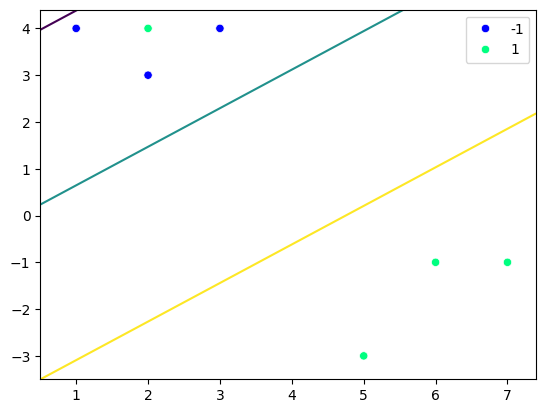

In [14]:
def plot(X, y, alphas, b, kernel):
    # visulize the decision hyperplane on the dataset
    x_min = min(X[:, 0]) - 0.5 # get boundry of the figure, x y here are coordinate axis
    x_max = max(X[:, 0]) + 0.5
    y_min = min(X[:, 1]) - 0.5
    y_max = max(X[:, 1]) + 0.5
    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    d = np.array([[x1, x2] for x1, x2 in zip(np.ravel(xx), np.ravel(yy))])
    Z = np.zeros(len(d))
    for i in range(len(d)): 
        Z[i] = f(d[i], X, y, alphas, b, kernel)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax, palette='winter') # draw the data points
    ax.contour(xx, yy, Z, levels=[-1, 0, 1]) # draw the hyperplane
    plt.show()
    
X = np.array([[3, 4], [1, 4],[2, 3], [6, -1], [7, -1], [5, -3], [2, 4]])
y = np.array([-1, -1, -1, 1, 1, 1, 1])
alphas, b = svm_qp(X, y, C=0.1, kernel=linear_kernel)
plot(X, y, alphas, b, kernel=linear_kernel)

#### Q3. While the data can be classified by soft-margin SVM, we still don't know which parameter can realize the "best" performance. Run with different penalty parameters $C$ and try to find an "optimal" value. Compare and analyze you results, e.g. why it is an optimal parameter, what is happening as $C$ is getting larger(smaller).

     pcost       dcost       gap    pres   dres
 0: -4.0119e-01 -1.7085e-01  2e+01  4e+00  2e-16
 1: -1.1689e-01 -1.5107e-01  8e-01  2e-01  4e-16
 2: -3.0457e-02 -9.9556e-02  7e-02  2e-17  8e-16
 3: -3.5212e-02 -4.2482e-02  7e-03  3e-18  3e-16
 4: -3.6764e-02 -3.8488e-02  2e-03  3e-18  2e-16
 5: -3.7402e-02 -3.7853e-02  5e-04  3e-18  1e-16
 6: -3.7499e-02 -3.7504e-02  5e-06  3e-18  1e-16
 7: -3.7500e-02 -3.7500e-02  5e-08  4e-18  2e-16
Optimal solution found.
C = 0.01, Accuracy = 0.67
     pcost       dcost       gap    pres   dres
 0: -4.2819e-01 -8.7884e-01  2e+01  4e+00  3e-16
 1: -1.5629e-01 -8.1592e-01  7e-01  6e-16  3e-16
 2: -1.6818e-01 -2.0908e-01  4e-02  6e-17  2e-16
 3: -1.7767e-01 -1.7845e-01  8e-04  4e-17  8e-17
 4: -1.7778e-01 -1.7778e-01  8e-06  4e-17  6e-17
 5: -1.7778e-01 -1.7778e-01  8e-08  5e-17  2e-16
Optimal solution found.
C = 0.1, Accuracy = 1.00
     pcost       dcost       gap    pres   dres
 0: -6.1943e-01 -9.2725e+00  4e+01  2e+00  3e-16
 1: -1.9332e-01 -4.378

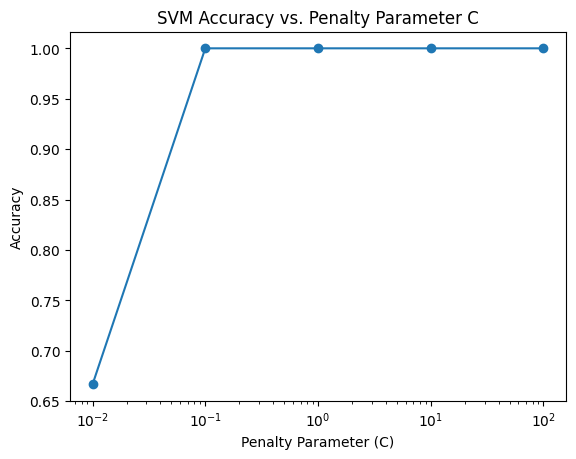

In [16]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_svm(X, y, alphas, b_svm, kernel):
    # Predict function using the learned SVM
    predictions = np.array([np.sign(f(x, X, y, alphas, b_svm, kernel)) for x in X])
    return accuracy_score(y, predictions)

# Sample range of C values to test (e.g., from very small to large)
C_values = [0.01, 0.1, 1, 10, 100]

# Data (use your own dataset or a simple one)
X = np.array([[2, 2], [1, 1], [2, 0], [0, 2], [-2, -2], [-1, -1]])
y = np.array([1, 1, 1, 1, -1, -1])

# Store results
results = []

for C in C_values:
    # Train SVM for each value of C
    alphas, b_svm = svm_qp(X, y, C, kernel=linear_kernel)
    
    # Evaluate SVM on the same training set (or use a separate validation set)
    accuracy = evaluate_svm(X, y, alphas, b_svm, kernel=linear_kernel)
    
    results.append((C, accuracy))
    print(f'C = {C}, Accuracy = {accuracy:.2f}')

# Plot accuracy as a function of C
C_vals, accuracies = zip(*results)
plt.plot(C_vals, accuracies, marker='o')
plt.xscale('log')  # Use logarithmic scale for better visualization
plt.xlabel('Penalty Parameter (C)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy vs. Penalty Parameter C')
plt.show()


*Analyze the Impact of $C$*
* Small $C$: When $C$ is small, the SVM tends to allow more misclassified points, meaning it favors a wider margin but at the cost of higher misclassification.  
* Large $C$: When $C$ is large, the SVM aims to classify all training points correctly, which tightens the margin.

#### Q4. When the data set is not linearly separable, we need to utilize different kernel functions. Here is a non-linear dataset, please test different kernel functions (e.g. Polynomial kernel and RBF kernel) and choose one to fit a soft-margin SVM model on it. 

In [19]:
# Generate half moon data (ref: https://shadow-ssml.readthedocs.io/en/latest/examples/halfmoons_example.html)
# parameters for data generation, you may modify them for further observation and comparison
n_samples = 100  # number of samples to generate
noise = 0.1  # noise to add to sample locations
X, y = datasets.make_moons(n_samples=n_samples, noise=noise)
y = (y - 0.5) * 2

# Train SVM with different kernels
def rbf_kernel(x1, x2, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

def polynomial_kernel(x1, x2, degree=3, gamma=1, coef0=1):
    return (gamma * np.dot(x1, x2) + coef0) ** degree


     pcost       dcost       gap    pres   dres
 0:  2.2412e+02 -3.4588e+03  5e+03  2e-01  5e-15
 1:  8.3209e+01 -4.8630e+02  6e+02  1e-02  3e-15
 2: -1.9747e+01 -1.3594e+02  1e+02  1e-03  3e-15
 3: -4.2705e+01 -8.4655e+01  4e+01  3e-04  3e-15
 4: -4.9714e+01 -8.1688e+01  3e+01  2e-04  2e-15
 5: -5.7943e+01 -6.9175e+01  1e+01  5e-05  2e-15
 6: -5.9746e+01 -6.6255e+01  7e+00  8e-06  2e-15
 7: -6.0339e+01 -6.5446e+01  5e+00  5e-06  3e-15
 8: -6.2048e+01 -6.2974e+01  9e-01  8e-07  2e-15
 9: -6.2325e+01 -6.2601e+01  3e-01  2e-15  2e-15
10: -6.2440e+01 -6.2455e+01  1e-02  2e-15  3e-15
11: -6.2446e+01 -6.2447e+01  5e-04  4e-15  3e-15
12: -6.2447e+01 -6.2447e+01  9e-06  7e-15  3e-15
Optimal solution found.


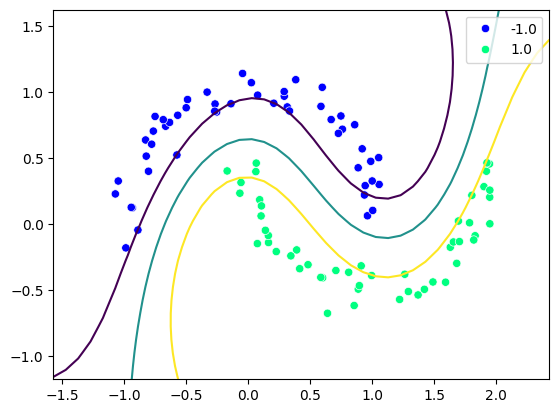

In [21]:
alphas, b = svm_qp(X, y, C=10, kernel=rbf_kernel)
plot(X, y, alphas, b, kernel=rbf_kernel)

     pcost       dcost       gap    pres   dres
 0:  5.3210e+01 -4.7307e+03  1e+04  5e-01  6e-14
 1:  1.2377e+02 -8.7819e+02  1e+03  3e-02  4e-14
 2:  3.2629e+01 -1.3266e+02  2e+02  3e-03  1e-14
 3: -2.4293e+00 -2.4074e+01  2e+01  5e-05  1e-14
 4: -6.9332e+00 -1.6938e+01  1e+01  2e-05  2e-14
 5: -1.0938e+01 -1.5270e+01  4e+00  2e-06  1e-14
 6: -1.1270e+01 -1.4975e+01  4e+00  1e-06  1e-14
 7: -1.2635e+01 -1.2976e+01  3e-01  4e-08  1e-14
 8: -1.2758e+01 -1.2766e+01  8e-03  9e-10  2e-14
 9: -1.2761e+01 -1.2761e+01  8e-05  1e-11  1e-14
10: -1.2761e+01 -1.2761e+01  8e-07  1e-13  1e-14
Optimal solution found.


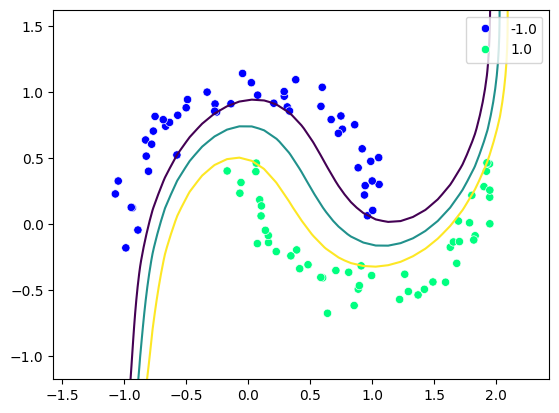

In [20]:
alphas, b = svm_qp(X, y, C=10, kernel=polynomial_kernel)
plot(X, y, alphas, b, kernel=polynomial_kernel)

* **Polynomial Kernel** is suitable for cases where there are complex polynomial relationships between the data points. By adjusting the degree $d$, you can control the complexity of the model.
* **RBF Kernel** is one of the most commonly used nonlinear kernels, allowing the model to separate data linearly in higher dimensions. The value of $\gamma$ controls the sensitivity of the model to distances between points.

## Part II: Hinge Loss for Binary Classification (Bonus Question)

Beside SVM, here we also introduce Hinge Loss, which formulates the binary classification loss as:
\begin{equation}
    L(y) = max(0, c - y \cdot \hat y),
\end{equation}
where $c$ is a hyperparameter (usually $1$), $y$ is the true label ($\pm 1$) and $\hat y$ is the prediction ([-1, 1]). As the predictions get further and further away from the true labels, the loss also gets larger. Additionally, once the prediction is correct ($y \cdot \hat y$), the loss is $0$ to avoid overconfidence. 

Actually, using Hinge Loss for binary classfication is equivalent to soft-margin SVM by considering an L2 regularization. The problem of using Hinge Loss for binary classification can be formulated as:
$$
   \text{minimize} \frac{1}{N} \sum_i max(0, 1 - y_i(W^T x_i + b)) + \lambda ||W||^2.
$$
If you are familiar with soft-margin SVM, you will easily find the equivalence by denoting  $ \zeta_i = max(0, 1 - y_i(W^T x_i + b))$:
$$
   \text{minimize} \frac{1}{N} \sum_i \zeta_i + \lambda ||W||^2, \\
   \text{subject to} \quad \zeta_i > 0,\quad  1 - y_i(W^T x_i + b) \le \zeta_i \quad \text{for all $i$},
$$
which is exactly the formulation of soft-margin SVM.


In this section, we will use Hinge Loss as the loss function of Stochastic Gradient Descent (SGD) method to classfy 0 and 1 in MNIST. (If you are not familiar with the mechanism of auto differentiation in Pytorch, you can refer to https://d2l.ai/chapter_preliminaries/autograd.html)

First we need to load MNIST dataset.

In [1]:
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

device =  "cpu" # we will use cpu in this assignment
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])
path = './data/'
TRAIN_DATA = torchvision.datasets.MNIST(path, train = True,transform = transform, download = True)
VAL_DATA = torchvision.datasets.MNIST(path, train = False,transform = transform, download = True)

Only data labelled as 0 and 1 is needed, so we preprocess data with the following function:

In [2]:
def prepare_data(data, label, num_samples):
    # Filter the dataset to include only the specified labels
    # data: the original dataset
    # label(list): needed labels, e.g. [0, 1]
    # num_samples(list): samples for each label
    
    indices = [i for i, (img, lbl) in enumerate(data) if lbl in label]
    filtered_data = torch.utils.data.Subset(data, indices)
    
    # Further reduce the dataset to the specified number of samples per label
    label_counts = {lbl: 0 for lbl in label}
    selected_indices = []
    
    for i in indices:
        _, lbl = data[i]
        if label_counts[lbl] < num_samples[label.index(lbl)]:
            selected_indices.append(i)
            label_counts[lbl] += 1
        if all(count >= num_samples[label.index(lbl)] for count in label_counts.values()):
            break
    
    final_data = torch.utils.data.Subset(data, selected_indices)
    
    # Create DataLoader for the preprocessed data
    data_loader = torch.utils.data.DataLoader(final_data, batch_size=1, shuffle=True)
    
    return final_data, data_loader

train_data, train_data_loader = prepare_data(TRAIN_DATA, label=[0,1], num_samples=[200,200])
val_data, val_data_loader = prepare_data(VAL_DATA, label=[0,1], num_samples=[50,50])



#### Q5 (Optional): Then we need to implement Hinge Loss in Equation(1) function with `Torch`.

In [8]:
def hinge_loss(preds, targets, c=1):
    # calculate hinge loss with torch tensor
    # preds: Batch_size x 1, predicted scores
    # targets: Batch_size x 1, ground truth labels
    # loss: Real number, hinge loss for preds and targets
    """ Your Code here """
    targets = targets.float().view_as(preds)  # Ensure targets are float and match the shape of preds
    loss = torch.mean(torch.clamp(c - preds * targets, min=0))  # Calculate the hinge loss
    return loss
    """ Your Code here """
    

#### Q6 (Optional): Finally implement the training loop. (It might take a minute for training.)

100%|██████████| 80/80 [00:13<00:00,  5.92it/s]


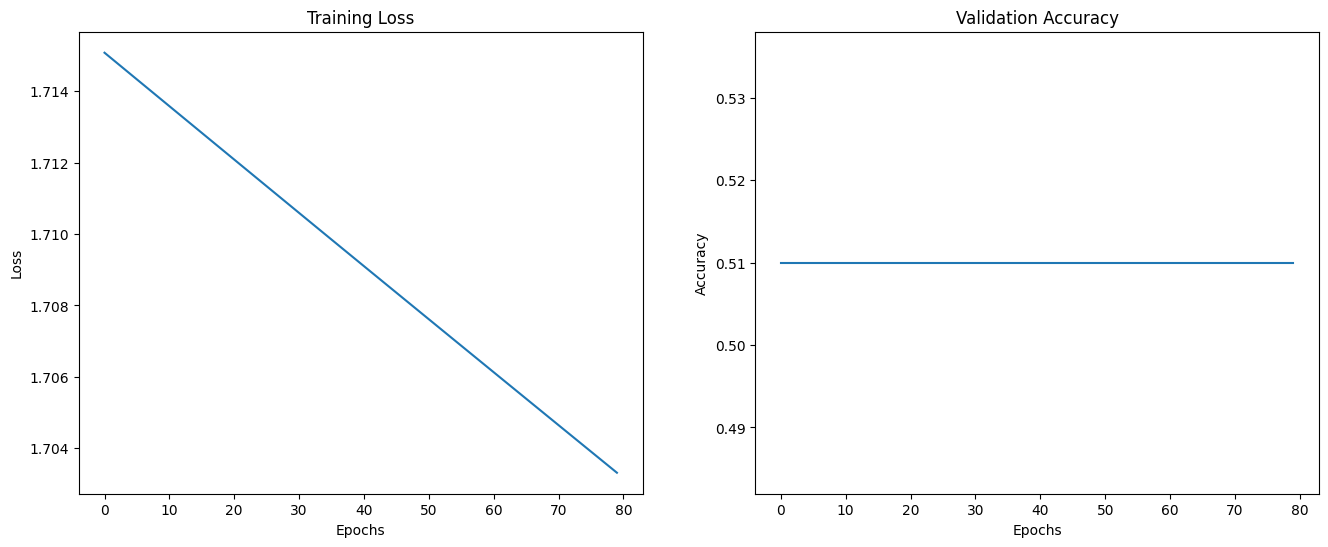

In [9]:
import torch
# some hyperparameters
lr=1e-4
epochs=80
l2_lambda=1e-3

# initialize linear model
# requires_grad = True to make w and b trainable
w=torch.randn(784,1,requires_grad=True)
b=torch.randn(1,requires_grad=True)

# optimizer
optimizer=torch.optim.SGD([w,b],lr=lr)

losses=[]
accuracy=[]
# training
for epoch in tqdm(range(epochs)):
    avg_loss = 0

    # correct_predictions = 0

    for i,(img,lbl) in enumerate(train_data_loader):
        # forward propogate
        # calulate the predicted scores and loss
        # You may use the hinge_loss function in Q5
        # hint: to ensure the robustness of the model, you may add L2 regularization term to the loss function 
        # 
        """ Your Code here """
         # Flatten and normalize images to [0, 1]
        img = img.view(-1, 784) / 255.0
        
        # Forward propagation
        preds = torch.matmul(img, w) + b  # Calculate predicted scores

        # Ensure labels are in the correct format: from [0, 1] to [-1, 1]
        lbl_transformed = (lbl * 2) - 1  # Transform labels to [-1, 1]

        # Calculate Hinge Loss and include L2 regularization
        hinge_loss_value = hinge_loss(preds, lbl_transformed, c=1)  # Calculate hinge loss
        l2_reg = l2_lambda * torch.norm(w) ** 2  # Calculate L2 regularization term
        loss = hinge_loss_value + l2_reg  # Total loss
        """ Your Code here """
        # backward propogate
        # update the weights and bias using torch optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()

        #  # Calculate accuracy
        # preds_binary = (preds.squeeze() > 0).int()
        # correct_predictions += (preds_binary == lbl).sum().item()

    # record average loss at each epoch
    avg_loss/=len(train_data_loader)
    losses.append(avg_loss)

    # avg_accuracy = correct_predictions / len(train_data_loader.dataset)
    # accuracy.append(avg_accuracy)

    # # Print epoch stats for better monitoring
    # print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    
    # validation
    # test the model on validation set and calculate the accuracy at each epoch
    avg_accu = 0
    # When testing, we need to shut requires_grad_ down to prevent the model being trained on the validation set
    w.requires_grad_(False)
    b.requires_grad_(False)
    # torch.no_grad shuts down the automatic calculation of gradients
    with torch.no_grad():
        for i,(img,lbl) in enumerate(val_data_loader):
            img=img.view(-1,784)
            preds=torch.matmul(img,w)+b
            preds = (preds.squeeze() > 0).int()
            accu = (preds == lbl).float().mean()  
            avg_accu += accu.item()
    # record the testing accuracy at each epoch 
    avg_accu /= len(val_data_loader)    
    accuracy.append(avg_accu)
    # after validation, we need to make w and b trainable again
    w.requires_grad_(True)
    b.requires_grad_(True)

# plot the training loss and validation accuracy
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1,2,2)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

#### Q7(Optional): Replace Hinge Loss with [Binary Cross-Entropy(BCE) Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Train the model using both loss functions separately, then compare the performance in terms of accuracy, convergence speed, and any other relevant metrics. Analyze and discuss the differences in the results.

In [15]:
import torch.nn.functional as F

def bce_loss(preds, targets):
    # Calculate BCE loss
    return F.binary_cross_entropy(preds, targets)


100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


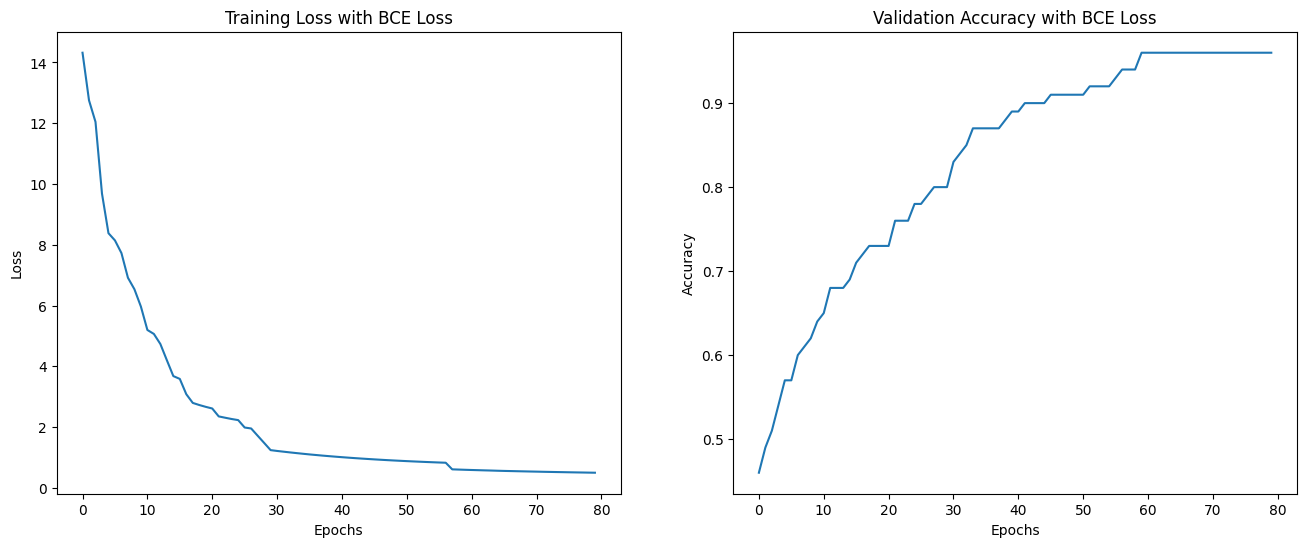

In [16]:
# some hyperparameters
lr = 1e-4
epochs = 80

# initialize linear model
w = torch.randn(784, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# optimizer
optimizer = torch.optim.SGD([w, b], lr=lr)

losses_bce = []
accuracy_bce = []

# training
for epoch in tqdm(range(epochs)):
    avg_loss = 0
    for i, (img, lbl) in enumerate(train_data_loader):
        # forward propagate
        img = img.view(-1, 784)  # Flatten the image
        preds = torch.sigmoid(torch.matmul(img, w) + b)  # Sigmoid activation for BCE
        targets = lbl.float().view(-1, 1)  # Ensure targets are float and match shape

        # Calculate BCE loss
        loss = bce_loss(preds, targets)

        # backward propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_data_loader)
    losses_bce.append(avg_loss)

    # validation
    avg_accu = 0
    w.requires_grad_(False)
    b.requires_grad_(False)

    with torch.no_grad():
        for i, (img, lbl) in enumerate(val_data_loader):
            img = img.view(-1, 784)
            preds = torch.sigmoid(torch.matmul(img, w) + b)
            preds = (preds.squeeze() > 0.5).int()  # Thresholding at 0.5
            accu = (preds == lbl).float().mean()
            avg_accu += accu.item()

    avg_accu /= len(val_data_loader)
    accuracy_bce.append(avg_accu)
    w.requires_grad_(True)
    b.requires_grad_(True)

# Plot training loss and validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(losses_bce)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss with BCE Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_bce)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy with BCE Loss')
plt.show()
